In [68]:
import numpy as np
import matplotlib.pyplot as plt
import random

VALID_ACTIONS = (0, 1, 2, 3)
OBSTACLES = [[(1, 1), (3, 3)],
                    [(1, 1), (2, 2), (3, 3), (4, 4), (6, 6), (7, 7), (8, 8), (3, 4), (3, 5), (7, 8), (6, 8), (8, 7), (6, 7), ],
                    [(2, 4), (2, 5), (2, 6), (2, 8), (2, 9), (2, 10), (3, 10), (6, 14), (6, 11), (6, 12), (6, 13), (2, 7),
                    (3, 7), (4, 7), (5, 7), (9, 3), (10, 3), (10, 4), (10, 5), (10, 6), (6, 10), (10, 7),
                    (10, 8), (14, 12), (13, 12), (12, 12), (11, 12), (10, 12)]]
START_STATE = (0, 0)
GOAL_REWARD = 100
STEP_REWARD = 0
LOSE_REWARD = -1
class Env:
    def __init__(self, grid_size=5):
        #define obstacles states here
        self.create_env(grid_size)
        self.noise = 0.2
        self.finished = False
        self.imshow = False
        self.verbose = False 
        self.valid_actions = VALID_ACTIONS
        self.states = []
        for i in range(grid_size):
            for j in range(grid_size):
                self.states.append((i,j))

    def create_env(self, grid_size):
        if grid_size not in (5, 10, 15):
            print('grid size is not valid, 5 is chosen by default')
            grid_size = 5
        self.grid_size = grid_size
        self.goal_state = (grid_size - 1, grid_size - 1)
        self.lose_state = (grid_size // 2, grid_size // 2)
        self.obstacles = OBSTACLES[(grid_size // 5) - 1]
        self.map = np.zeros((grid_size, grid_size))
        self.state = START_STATE
        self.map[self.goal_state] = 3
        self.map[self.lose_state] = -1
        for o in self.obstacles:
            self.map[o] = 2

    def set_imshow(self, show=True):
        self.imshow = show

    def set_verbose(self, verbose=False):
        self.verbose = verbose

    def set_noise(self, noise=0.2):
        if noise > 1:
            noise = 1
        elif noise < 0:
            noise = 0
        self.noise = noise

    def get_reward(self, state):
        if state == self.goal_state:
            return GOAL_REWARD
        elif state == self.lose_state:
            return LOSE_REWARD
        else:
            return STEP_REWARD

    def step(self, action):

        if action not in self.valid_actions:
            return 'action not valid'

        done = False

        if np.random.random() < self.noise:
            action = np.random.randint(0, 4)

        state = self.state
        self.map[state] = 0

        if action == 0:
            next_state = (max(0, state[0] - 1), state[1])
        elif action == 1:
            next_state = (state[0], min(self.grid_size - 1, state[1] + 1))
        elif action == 2:
            next_state = (state[0], max(0, state[1] - 1))
        elif action == 3:
            next_state = (min(self.grid_size - 1, state[0] + 1), state[1])

        if next_state in self.obstacles:
            return -1, state, done
        else:
            reward = self.get_reward(next_state)
            self.state = next_state

            if next_state == self.lose_state:
                if self.verbose:
                    print('you lost')
                done = True
                self.reset()
            elif next_state == self.goal_state:
                if self.verbose:
                    print('you won')
                done = True
                self.reset()
            else:
                self.map[next_state] = 1

                if self.verbose:
                    self.print_env()

            return reward,next_state,done

    def print_env(self):
        self.map[self.state] = 1
        if self.imshow:
            #plt.imshow(self.map, cmap='RdGy')
            #plt.show()
            cv2.imshow('RdGy', self.map)
        else:
            print(self.map)

    def reset(self, exploring = True):
        if not exploring:
            self.create_env(self.grid_size)
        else:
            self.state = START_STATE
        
        if self.verbose:
            self.print_env()
        return self.state


In [69]:
def CreateQtabels(sz,actions):
    q_table={}
    for n in range(5):
        for m in range(5):
            qvalues=np.random.rand(actions,)/4
            s=(n,m)
            q_table[str(s)]=qvalues
    return q_table

def choose_action(state,actions,ep,q_table):
    if np.random.uniform() < ep:
        state_action = q_table[state]
        action = np.argmax(state_action)
    else:
        action = np.random.choice(actions)
    return action
def train_SARSA(state, action, reward, next_state, next_action,done,Q_TABLE,discount,LR):
    q_predict = Q_TABLE[state][action]
    if not done:
        q_target = reward + discount * Q_TABLE[next_state][next_action]
    else:
        q_target = reward

    Q_TABLE[state][action] += LR * (q_target - q_predict)
    return Q_TABLE[state][action]

def train_Qleaning(state, action, reward, next_state,done,Q_TABLE,discount,LR):
    q_predict = Q_TABLE[state][action]
    if not done:
        q_target = reward + discount * Q_TABLE[next_state].max()
    else:
        q_target = reward
    Q_TABLE[state][action] += LR * (q_target - q_predict)
    return Q_TABLE[state][action]


def plot_results(steps, costs):
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.plot(np.arange(len(steps)), steps, 'g')
    ax1.set_title('steps')
    
    ax2.plot(np.arange(len(costs)), costs, 'r')
    ax2.set_title('costs')

    plt.show()

Average reward : 5.019274523819515  and average Step : 27.0125 


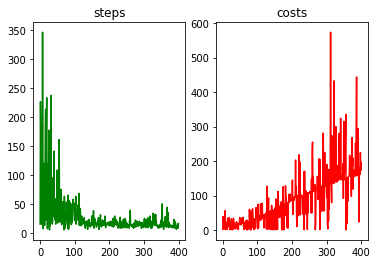

In [70]:
#####################################################################
##################   SARSA  alghorithm  #########################

env_size=5
env = Env(5)
Actions=len(VALID_ACTIONS)

Sarsa_Qtable = CreateQtabels(env_size,Actions)

LR=0.01
discount_r=0.9
RandomProb=0.8

steps = []
costs = []
Averag_Steps=0
AverageReward=0
epochs=400
for episod in range(epochs):
    state = env.reset()
    step_ = 0
    cost = 0
    SUM_rewards=0
    # RL choose action based on state
    action = choose_action(str(state),Actions,RandomProb,Sarsa_Qtable)

    while True:
        # step on env to get new reward ,state,done
        reward, state2, done = env.step(action)
        SUM_rewards+=reward
        action2 = choose_action(str(state2),Actions,RandomProb,Sarsa_Qtable)

        # update Q_table
        
        temp= train_SARSA(str(state), action, reward, str(state2), action2,done,Sarsa_Qtable,discount_r,LR)
        cost +=temp
        ### save new state and state for next loop
        state = state2
        action = action2

        # plus to steps in this loop
        step_ += 1
        if done:
            steps += [step_]
            Averag_Steps+=step_
            AverageReward+=SUM_rewards/step_
            costs += [cost]
            break

print(f'Average reward : {AverageReward/epochs}  and average Step : {Averag_Steps/epochs} ')
plot_results(steps, costs)

In [71]:
print('****************** Qtable ******************')
print(Sarsa_Qtable)
print('****************** map  ******************')
print(env.map)

****************** Qtable ******************
{'(0, 0)': array([0.05737967, 0.06354159, 0.05595365, 0.05466718]), '(0, 1)': array([ 0.03581292,  0.19922803,  0.01653891, -0.1714076 ]), '(0, 2)': array([0.12789537, 0.72083007, 0.05720198, 0.11476222]), '(0, 3)': array([0.17169519, 2.38240252, 0.13425999, 0.35800533]), '(0, 4)': array([0.34534167, 0.30280891, 0.1708716 , 7.87488733]), '(1, 0)': array([ 0.02573935, -0.11557599,  0.02105378,  0.01748206]), '(1, 1)': array([0.07508745, 0.01325283, 0.15024315, 0.09711811]), '(1, 2)': array([ 0.01826862,  0.56909159,  0.01382432, -0.00859307]), '(1, 3)': array([0.25199525, 0.56753262, 0.50823187, 4.56700707]), '(1, 4)': array([ 1.10464501,  1.2887734 ,  1.21589911, 22.04018996]), '(2, 0)': array([0.0782736 , 0.07829863, 0.04892594, 0.04970057]), '(2, 1)': array([-0.0131266 , -0.01690862, -0.01580145,  0.02123477]), '(2, 2)': array([0.00031709, 0.16022038, 0.02409533, 0.17526875]), '(2, 3)': array([ 0.2335798 , 16.68932888, -0.02762838,  0.3295

Average reward : 5.521333861760729  and average Step : 25.955 


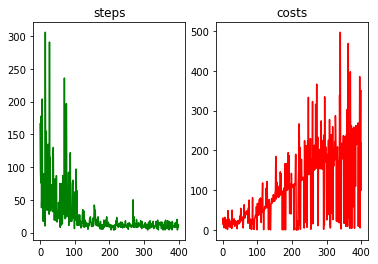

In [72]:

#####################################################################
##################   Q learning alghorithm  #########################
env_size=5
env = Env(5)
Actions=len(VALID_ACTIONS)

Qlearning_Qtable = CreateQtabels(env_size,Actions)

LR=0.01
discount_r=0.9
RandomProb=0.8

steps = []
costs = []
Averag_Steps=0
AverageReward=0
epochs=400
for episod in range(epochs):
    state = env.reset()
    step_ = 0
    cost = 0
    SUM_rewards=0
    # RL choose action based on state
    action = choose_action(str(state),Actions,RandomProb,Qlearning_Qtable)

    while True:
        # step on env to get new reward ,state,done
        reward, state2, done = env.step(action)
        SUM_rewards+=reward
        action2 = choose_action(str(state2),Actions,RandomProb,Qlearning_Qtable)

        # update Q_table
        temp= train_Qleaning(str(state), action, reward, str(state2),done,Qlearning_Qtable,discount_r,LR)
        cost +=temp
        ### save new state and state for next loop
        state = state2
        action = action2

        # plus to steps in this loop
        step_ += 1
        if done:
            steps += [step_]
            Averag_Steps+=step_
            AverageReward+=SUM_rewards/step_
            costs += [cost]
            break

print(f'Average reward : {AverageReward/epochs}  and average Step : {Averag_Steps/epochs} ')
plot_results(steps, costs)

In [73]:
print('****************** Qtable ******************')
print(Qlearning_Qtable)
print('****************** map  ******************')
print(env.map)

****************** Qtable ******************
{'(0, 0)': array([0.07781274, 0.06937313, 0.07405889, 0.56790789]), '(0, 1)': array([ 0.0435718 ,  0.05899305,  0.08852444, -0.19771287]), '(0, 2)': array([0.04731171, 0.14064831, 0.1400643 , 0.0866786 ]), '(0, 3)': array([0.10790123, 0.07160597, 0.09604252, 0.1030177 ]), '(0, 4)': array([0.08290225, 0.1503129 , 0.14998011, 0.08405868]), '(1, 0)': array([ 0.05908655, -0.11018449,  0.06314079,  1.43799872]), '(1, 1)': array([0.05496524, 0.19873878, 0.210464  , 0.09086402]), '(1, 2)': array([0.03878486, 0.17661999, 0.03628126, 0.16252171]), '(1, 3)': array([0.16965293, 0.229414  , 0.0493627 , 0.06110146]), '(1, 4)': array([0.18789658, 0.05741125, 0.08679319, 0.84574661]), '(2, 0)': array([0.22929682, 3.3438149 , 0.35401184, 0.17348227]), '(2, 1)': array([ 4.44689712e-01, -2.96472498e-03,  2.73381549e-01,  7.54060343e+00]), '(2, 2)': array([0.01892236, 0.03995194, 0.01925704, 0.13453204]), '(2, 3)': array([0.09911502, 0.28643277, 0.01832566, 0.

Average reward : 1.8621135153473491  and average Step : 18.725 


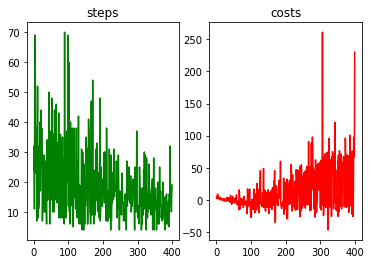

****************** Qtable ******************
{'(0, 0)': array([-2.22320454, -2.21624579, -2.22096622, -2.22176751]), '(0, 1)': array([-1.66033678, -1.66035405, -1.65840689, -1.664155  ]), '(0, 2)': array([-1.00279796, -0.99829607, -1.00682343, -0.98446414]), '(0, 3)': array([-0.56986082, -0.55961375, -0.55721054, -0.55688689]), '(0, 4)': array([-0.26567209, -0.26638877, -0.28222176, -0.12934612]), '(1, 0)': array([-1.80977859, -1.81601896, -1.80338863, -1.79933989]), '(1, 1)': array([0.13598138, 0.19229698, 0.21671448, 0.03825301]), '(1, 2)': array([-0.47619499, -0.47858006, -0.48796233, -0.47256409]), '(1, 3)': array([-0.2784227 , -0.06958529, -0.29670882, -0.26247001]), '(1, 4)': array([-0.13924822, -0.07961711, -0.01360959,  3.63134774]), '(2, 0)': array([-1.17295362, -1.16328547, -1.17672615, -1.16332952]), '(2, 1)': array([-0.58809035, -0.58275854, -0.58484348, -0.58542573]), '(2, 2)': array([0.0914711 , 0.08915343, 0.13755113, 0.17535158]), '(2, 3)': array([-0.00407282,  1.340953

In [74]:
#####################################################################
##################    changed Reward to -1  #########################
STEP_REWARD = -1

#####################################################################
##################    SARSA alghortithm  #########################
env_size=5
env = Env(5)
Actions=len(VALID_ACTIONS)

Sarsa_Qtable = CreateQtabels(env_size,Actions)

LR=0.01
discount_r=0.9
RandomProb=0.8

steps = []
costs = []
Averag_Steps=0
AverageReward=0
epochs=400
for episod in range(epochs):
    state = env.reset()
    step_ = 0
    cost = 0
    SUM_rewards=0
    # RL choose action based on state
    action = choose_action(str(state),Actions,RandomProb,Sarsa_Qtable)

    while True:
        # step on env to get new reward ,state,done
        reward, state2, done = env.step(action)
        SUM_rewards+=reward
        action2 = choose_action(str(state2),Actions,RandomProb,Sarsa_Qtable)

        # update Q_table
        
        temp= train_SARSA(str(state), action, reward, str(state2), action2,done,Sarsa_Qtable,discount_r,LR)
        cost +=temp
        ### save new state and state for next loop
        state = state2
        action = action2

        # plus to steps in this loop
        step_ += 1
        if done:
            steps += [step_]
            Averag_Steps+=step_
            AverageReward+=SUM_rewards/step_
            costs += [cost]
            break

print(f'Average reward : {AverageReward/epochs}  and average Step : {Averag_Steps/epochs} ')
plot_results(steps, costs)

print('****************** Qtable ******************')
print(Sarsa_Qtable)
print('****************** map  ******************')
print(env.map)

Average reward : 3.125831695134433  and average Step : 18.7775 


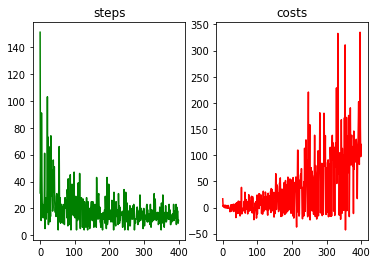

****************** Qtable ******************
{'(0, 0)': array([-2.27005933, -2.26772495, -2.27678303, -2.26857489]), '(0, 1)': array([-1.76325805, -1.75032814, -1.77351566, -1.75817181]), '(0, 2)': array([-1.10071228, -1.09506994, -1.09843711, -1.09707064]), '(0, 3)': array([-0.61154211, -0.59558987, -0.60823566, -0.57034888]), '(0, 4)': array([-0.29716786, -0.26375707, -0.2897959 ,  0.24330647]), '(1, 0)': array([-1.69990982, -1.70244834, -1.69999887, -1.69616263]), '(1, 1)': array([0.00104588, 0.22705504, 0.06124311, 0.23174867]), '(1, 2)': array([-0.52773961, -0.46843396, -0.48214575, -0.48790727]), '(1, 3)': array([-0.3403978 ,  1.10685678, -0.31853904, -0.26396427]), '(1, 4)': array([-0.12433267,  0.09519343, -0.09226301,  8.31671613]), '(2, 0)': array([-0.98699864, -0.98577494, -0.98760562, -0.9859589 ]), '(2, 1)': array([-0.34354751, -0.35377983, -0.3449634 , -0.27066152]), '(2, 2)': array([0.14437143, 0.11144307, 0.20579834, 0.05836899]), '(2, 3)': array([-0.03244127,  2.192745

In [75]:

#####################################################################
##################   Q learning alghorithm  #########################
env_size=5
env = Env(5)
Actions=len(VALID_ACTIONS)

Qlearning_Qtable = CreateQtabels(env_size,Actions)

LR=0.01
discount_r=0.9
RandomProb=0.8

steps = []
costs = []
Averag_Steps=0
AverageReward=0
epochs=400
for episod in range(epochs):
    state = env.reset()
    step_ = 0
    cost = 0
    SUM_rewards=0
    # RL choose action based on state
    action = choose_action(str(state),Actions,RandomProb,Qlearning_Qtable)

    while True:
        # step on env to get new reward ,state,done
        reward, state2, done = env.step(action)
        SUM_rewards+=reward
        action2 = choose_action(str(state2),Actions,RandomProb,Qlearning_Qtable)

        # update Q_table
        temp= train_Qleaning(str(state), action, reward, str(state2),done,Qlearning_Qtable,discount_r,LR)
        cost +=temp
        ### save new state and state for next loop
        state = state2
        action = action2

        # plus to steps in this loop
        step_ += 1
        if done:
            steps += [step_]
            Averag_Steps+=step_
            AverageReward+=SUM_rewards/step_
            costs += [cost]
            break

print(f'Average reward : {AverageReward/epochs}  and average Step : {Averag_Steps/epochs} ')
plot_results(steps, costs)

print('****************** Qtable ******************')
print(Qlearning_Qtable)
print('****************** map  ******************')
print(env.map)